In [1]:
import tqdm
import random
import pathlib
import itertools
import collections

import os
import cv2
import numpy as np
import pandas as pd
import remotezip as rz

import tensorflow as tf

# Some modules to display an animation using imageio.
import imageio
from IPython import display
from urllib import request
from tensorflow_docs.vis import embed

import tensorflow as tf
import tensorflow_hub as hub

In [3]:
metadata = pd.read_csv('metadata.csv')
metadata.head()

,bbox,fps,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id,gloss
0,"[385, 37, 885, 720]",25,-1,1,0,118,aslbrick,train,http://aslbricks.org/New/ASL-Videos/book.mp4,0,69241,book
1,"[190, 25, 489, 370]",25,-1,1,1,90,aslsignbank,train,https://aslsignbank.haskins.yale.edu/dictionar...,0,65225,book
2,"[262, 1, 652, 480]",25,-1,1,2,110,valencia-asl,train,https://www.youtube.com/watch?v=0UsjUE-TXns,0,68011,book
3,"[123, 19, 516, 358]",25,60,1,3,113,lillybauer,train,https://www.youtube.com/watch?v=1QOYOZ3g-aY,0,68208,book
4,"[95, 0, 1180, 720]",25,-1,1,4,109,valencia-asl,train,https://www.youtube.com/watch?v=aGtIHKEdCds,0,68012,book


In [4]:

DATA_PATH = os.path.join('experiment_subset')
actions = np.array(['hello', 'love', 'thank you'])
splits = metadata['split'].unique()

In [5]:
import shutil

for split in splits:
    for action in actions:
        vid_ids = metadata[(metadata['gloss'] == action) & (metadata['split'] == split)]['video_id'].unique()
        for id in vid_ids:
            file = 'C:/Users/rbcor/Sign-Language-Translator/videos/' + str(id) + '.mp4'
            move = os.path.join(DATA_PATH, split, action)
            if not os.path.exists(move):
                os.makedirs(move)
            #if not os.path.isfile(os.path.join(move, str(id), '.mp4')):
            try:
                shutil.move(file, move)
            except:
                continue

In [6]:
def frames_from_video_file(video_path, n_frames, output_size = (256,256)):
  """ Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  # If the number of frames wanted is greater than the length of the video, then start from beginning
  if n_frames > video_length:
    start = 0
  else:
    # Otherwise, start at another random point within the video
    max_start = video_length - n_frames
    start = random.randint(0, max_start)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)

  for _ in range(n_frames):
    ret, frame = src.read()
    if ret:
      frame = tf.image.convert_image_dtype(frame, tf.float32)
      frame = tf.image.resize_with_pad(frame, *output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  # Ensure that the color scheme is not inverted
  result = np.array(result)[..., [2, 1, 0]]

  return result

In [7]:
def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=10)
  return embed.embed_file('./animation.gif')

In [8]:
subset_paths = {'train': pathlib.WindowsPath(os.path.join(DATA_PATH, 'train')),
                'val': pathlib.WindowsPath(os.path.join(DATA_PATH, 'val')),
                'test': pathlib.WindowsPath(os.path.join(DATA_PATH, 'test'))}
print(subset_paths)

{'train': WindowsPath('experiment_subset/train'), 'val': WindowsPath('experiment_subset/val'), 'test': WindowsPath('experiment_subset/test')}



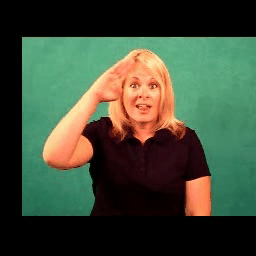

In [9]:
# docs-infra: no-execute
ucf_sample_video = frames_from_video_file(next(subset_paths['train'].glob('*/*.mp4')), 12)
to_gif(ucf_sample_video)

In [10]:
class FrameGenerator:
  def __init__(self, path, n_frames):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        classes: List of labels for classification.
    """
    self.path = path
    self.n_frames = n_frames
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.mp4'))
    classes = [p.parent.name for p in video_paths] 
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [11]:
fg = FrameGenerator(subset_paths['train'], 12)

frames, label = next(fg())

print(f"Shape: {frames.shape}")
print(f"Label: {label}")

Shape: (12, 256, 256, 3)
Label: 0


In [12]:
# Create the training set
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))
train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], 12),
                                          output_signature = output_signature)

In [13]:
# Create the validation set
val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], 12),
                                        output_signature = output_signature)

In [14]:
# Print the shapes of the data
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of training set of frames: (12, 256, 256, 3)
Shape of training labels: ()
Shape of validation set of frames: (12, 256, 256, 3)
Shape of validation labels: ()


In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [16]:
train_ds = train_ds.batch(2)
val_ds = val_ds.batch(2)

train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of training set of frames: (2, 12, 256, 256, 3)
Shape of training labels: (2,)
Shape of validation set of frames: (2, 12, 256, 256, 3)
Shape of validation labels: (2,)


In [17]:


hub_url = "https://tfhub.dev/tensorflow/movinet/a3/base/kinetics-600/classification/3"

encoder = hub.KerasLayer(hub_url, trainable=False)

inputs = tf.keras.layers.Input(
    shape=[None, None, None, 3],
    dtype=tf.float32,
    name='image')

# [batch_size, 600]
outputs = encoder(dict(image=inputs))

base_model = tf.keras.Model(inputs, outputs, name='movinet')

In [18]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax'),
    
], name="devins_movinet")

In [19]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [120]:
# model.fit(train_ds, 
#           epochs = 10,
#           validation_data = val_ds,
#           callbacks = tf.keras.callbacks.EarlyStopping(patience = 2, monitor = 'val_loss'))

Epoch 1/10
14/14 [==============================] - 491s 34s/step - loss: 1.1376 - accuracy: 0.5185 - val_loss: 1.3359 - val_accuracy: 0.6667
Epoch 2/10
14/14 [==============================] - 461s 33s/step - loss: 0.4705 - accuracy: 0.8519 - val_loss: 0.8009 - val_accuracy: 0.6667
Epoch 3/10
14/14 [==============================] - 462s 33s/step - loss: 0.3344 - accuracy: 0.8889 - val_loss: 0.5152 - val_accuracy: 0.6667
Epoch 4/10
14/14 [==============================] - 463s 33s/step - loss: 0.1148 - accuracy: 0.9630 - val_loss: 0.5024 - val_accuracy: 0.6667
Epoch 5/10
14/14 [==============================] - 463s 33s/step - loss: 0.0143 - accuracy: 1.0000 - val_loss: 0.4289 - val_accuracy: 0.6667
Epoch 6/10
14/14 [==============================] - 461s 33s/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 0.4507 - val_accuracy: 0.8333
Epoch 7/10
14/14 [==============================] - 460s 33s/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.4869 - val_accuracy: 0.8333


In [121]:
# model.save('devins_movinet_v1.h5')

In [20]:
# Loads the weights
model.load_weights('devins_movinet_v1.h5')

In [21]:
test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], 12),
                                          output_signature = output_signature)

test_frames, test_labels = next(iter(test_ds))
print(f'Shape of test set of frames: {test_frames.shape}')
print(f'Shape of test labels: {test_labels.shape}')

Shape of test set of frames: (12, 256, 256, 3)
Shape of test labels: ()


In [22]:
test_ds = test_ds.batch(1)

test_frames, test_labels = next(iter(test_ds))
print(f'Shape of training set of frames: {test_frames.shape}')
print(f'Shape of training labels: {test_labels.shape}')

Shape of training set of frames: (1, 12, 256, 256, 3)
Shape of training labels: (1,)


In [23]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [25]:
with tf.device('/CPU:0'):
    preds = model.predict(test_ds)

In [133]:
#ytrue = np.argmax(y_train, axis=1).tolist()
yhat = np.argmax(preds, axis=1).tolist()

In [134]:
yhat

[0, 0, 1, 2, 2, 2]

In [2]:
print(tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
